In [94]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.base import TransformerMixin

In [ ]:
#Objective: The Bank Needs To Predict Churn In Order To Preserve the Number of Clients.
#Try to get highest Recall precentage on 1 while the precision rates can't be lower than 50%.

In [2]:
# Loading The Data
bank_data=pd.read_csv("Bank Customer Churn Prediction.csv")
bank_data.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:

bank_data.describe()
#no missing values
#credit score between 350 and 850, mean 650
#age between 18 and 92
#products number between 1 and 4
#credit_card, active_member, churn (1 if left) are a boolean

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
bank_data.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [5]:
#Encoding String Features To Numeric Representations
bank_data['gender_encoded']=bank_data['gender'].map({'Female':0, 'Male':1})
bank_data['country_encoded']=bank_data['country'].map({'France':0, 'Spain':1, 'Germany':2})

In [6]:
#EDA Based On Feature Type
continuous_var = bank_data[['credit_score', 'estimated_salary', 'balance', 'age']]
binary_var = bank_data[['gender_encoded', 'credit_card', 'active_member']]
cat_var = bank_data[['gender_encoded', 'credit_card', 'active_member', 'products_number', 'tenure', 'country']]

In [7]:
bank_data['country'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

<AxesSubplot:xlabel='country', ylabel='Count'>

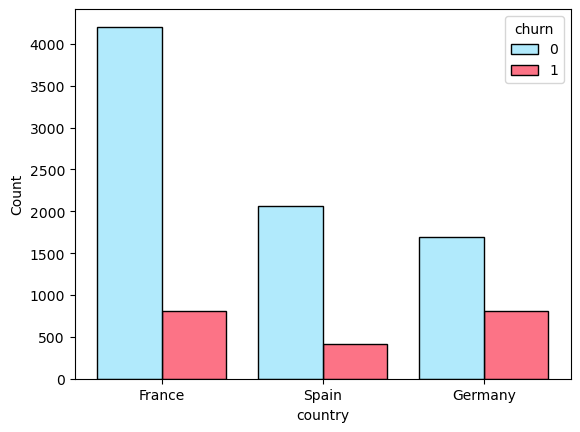

In [8]:
#countries by churn rate
sns.histplot(data=bank_data, x='country', hue='churn', multiple="dodge", shrink = .8, palette=["#97e3fc", "#fc445d"])

In [9]:
#check for duplicated indexes
bank_data.index.duplicated().sum()
# no dupes

0

In [10]:
(bank_data['churn']==1).mean()
#over the period 20% left the bank.

0.2037

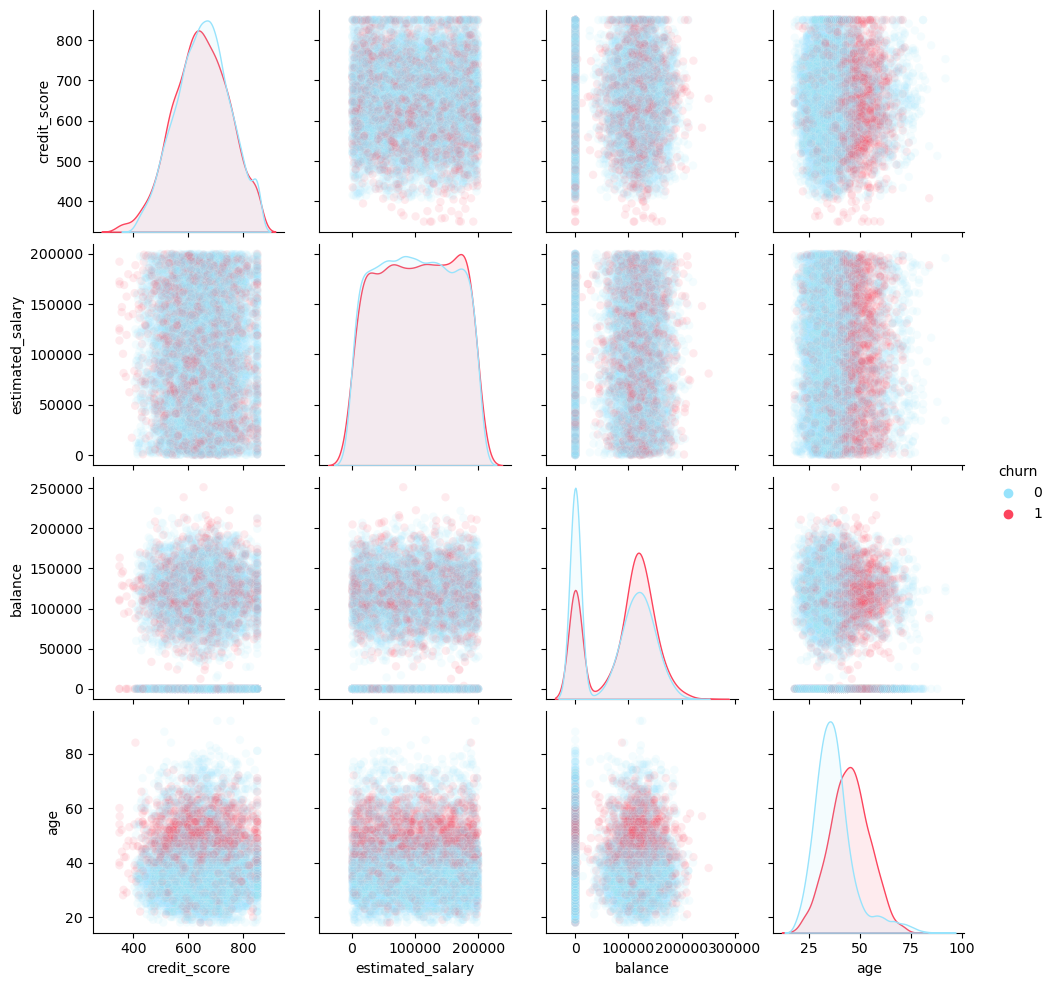

In [11]:
#seems like age can be important feature
def seperately_normed_pairplot (data, hue):
    g = sns.pairplot(data, hue=hue, palette=["#97e3fc", "#fc445d"],
        plot_kws={'alpha':0.1},
        diag_kws={"linewidth": 0, "shade": False})
    g.map_diag(sns.kdeplot, common_norm=False, shade= True, palette=["#97e3fc", "#fc445d"], alpha = 0.1)

data_v = bank_data[['credit_score', 'estimated_salary', 'balance', 'age', 'churn']]
seperately_normed_pairplot(data_v, 'churn')

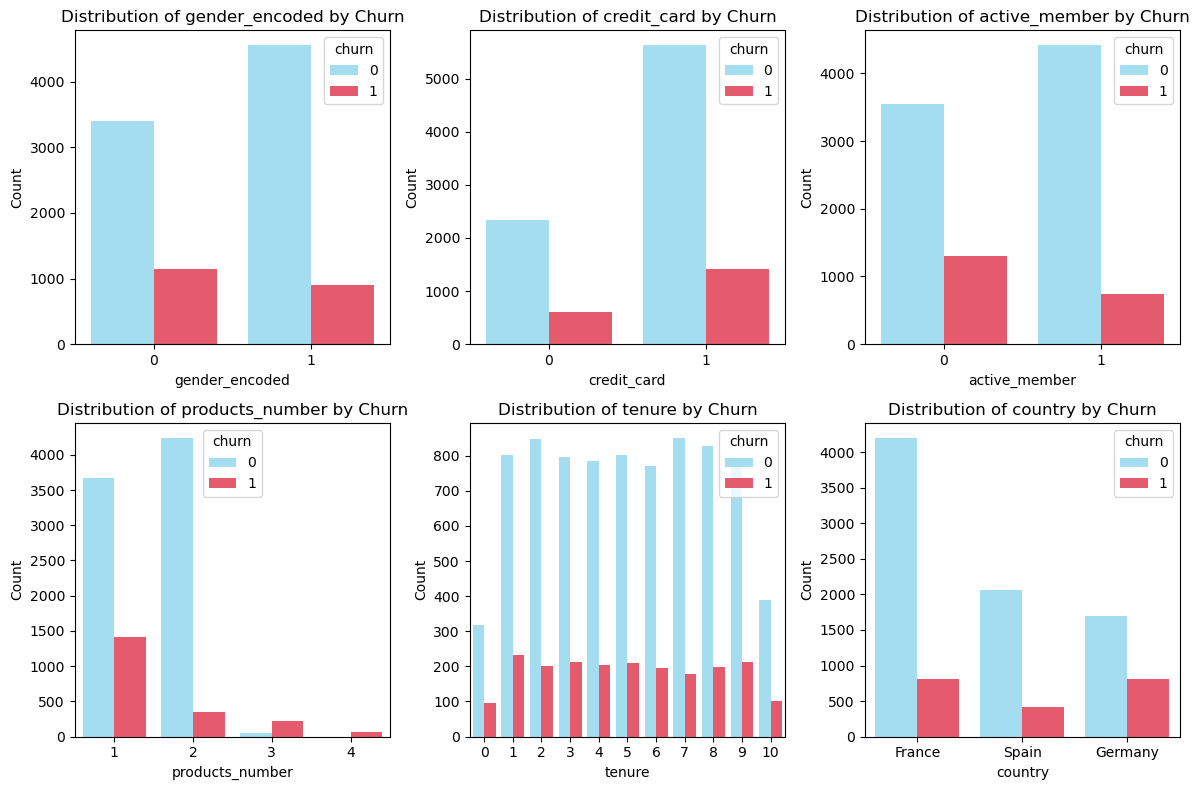

In [12]:
def churn_count_compare(data, explain_vars):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, column in enumerate(explain_vars):
        sns.countplot(data=data, x=column, hue='churn', palette=["#97e3fc", "#fc445d"], ax=axes[i])
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'Distribution of {column} by Churn')

    # Adjust the layout
    fig.tight_layout()

    # Show the plot
    plt.show()

churn_count_compare (bank_data, cat_var)

In [13]:
#Baseline Model: Precision of 1=0.58, Recall of 1=0.22. 
#Recall only slightly above chance levels 20%.

#hyper params
FEATURES= bank_data['age']

#fit
X, y= pd.DataFrame(FEATURES), bank_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

#predict
y_pred = pd.Series(model.predict(X_test), index = X_test.index)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_test, y_pred=y_pred)}")


Confusion Matrix 
       0    1
0  1921   82
1   386  111 

Stats Report 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      2003
           1       0.58      0.22      0.32       497

    accuracy                           0.81      2500
   macro avg       0.70      0.59      0.61      2500
weighted avg       0.78      0.81      0.78      2500



In [14]:
bank_data.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn', 'gender_encoded', 'country_encoded',
       'churn_pred'],
      dtype='object')

In [15]:
#got much nicer recall while using all features: recall 0.51 and precision 0.48. lets see how much better can it be.

#hyper params
FEATURES = bank_data[['age', 'tenure', 'credit_score', 'gender_encoded', 'estimated_salary', 'balance', 'products_number', 'country_encoded', 'active_member']]

#fit
X, y= pd.DataFrame(FEATURES), bank_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

#predict
y_pred = pd.Series(model.predict(X_test), index = X_test.index)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_test, y_pred=y_pred)}")

Confusion Matrix 
       0    1
0  1733  270
1   245  252 

Stats Report 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2003
           1       0.48      0.51      0.49       497

    accuracy                           0.79      2500
   macro avg       0.68      0.69      0.68      2500
weighted avg       0.80      0.79      0.80      2500



In [16]:
#is there overfitting? predict on train. Theres some serious overfitting here.

#predict
y_pred = pd.Series(model.predict(X_train), index = X_train.index)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_train, y_pred=y_pred)}")

Confusion Matrix 
       0     1
0  5960     0
1     0  1540 

Stats Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5960
           1       1.00      1.00      1.00      1540

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



In [137]:
#got much nicer recall while using all features: Got higher precision 0.76 but recall is 0.48.

#hyper params
FEATURES = bank_data[['age', 'gender_encoded', 'balance', 'products_number', 'country_encoded', 'active_member']]
MIN_IMPURITY_DECREASE=0.0005
#fit
X, y= pd.DataFrame(FEATURES), bank_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(min_impurity_decrease=MIN_IMPURITY_DECREASE, random_state=42)
model.fit(X_train, y_train)

#predict
y_pred = pd.Series(model.predict(X_test), index = X_test.index)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_test, y_pred=y_pred)}")

Confusion Matrix 
       0    1
0  1926   77
1   257  240 

Stats Report 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2003
           1       0.76      0.48      0.59       497

    accuracy                           0.87      2500
   macro avg       0.82      0.72      0.75      2500
weighted avg       0.86      0.87      0.85      2500



In [34]:
#Got To a Recall Rate of 70% while precision is 52%.

#hyper params
FEATURES = bank_data[['age', 'gender_encoded', 'balance', 'products_number', 'country_encoded', 'active_member']]
MIN_IMPURITY_DECREASE=0.0005
THRESHOLD = 0.22 #Lowering the threshold to predict a churner in order to raise recall.


#fit
X, y= pd.DataFrame(FEATURES), bank_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(min_impurity_decrease=MIN_IMPURITY_DECREASE, random_state=42)
model.fit(X_train, y_train)

#predict
y_pred_prob = pd.Series(model.predict_proba(X_test.values)[:, 1], index=X_test.index)
y_pred = (y_pred_prob >= THRESHOLD).astype(int)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Tree Depth: {model.tree_.max_depth} \n")
print(f"The Model Predicts {y_pred.sum()} Churners \n")
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_test, y_pred=y_pred)}")

Tree Depth: 8 

The Model Predicts 673 Churners 

Confusion Matrix 
       0    1
0  1678  325
1   149  348 

Stats Report 
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      2003
           1       0.52      0.70      0.59       497

    accuracy                           0.81      2500
   macro avg       0.72      0.77      0.74      2500
weighted avg       0.84      0.81      0.82      2500



c:\Users\Ellas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [106]:
# Trying To Handle imbalaced classes With Adjusted Class Weights 
# Adding Another Validation With Cross Validation

#hyper params
FEATURES = bank_data[['age', 'gender_encoded', 'balance', 'products_number', 'country_encoded', 'active_member']]
MIN_IMPURITY_DECREASE=0.0005
CLASS_WEIGHTS= {1: 4.4, 0: 1} #4.4 times more weight to churners


#fit
X, y= pd.DataFrame(FEATURES), bank_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(min_impurity_decrease=MIN_IMPURITY_DECREASE, class_weight = CLASS_WEIGHTS, random_state=42)
model.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='recall')  # X and y represent your data

print("Cross-validation scores:", scores)
print("Mean Recall:", scores.mean())


#predict
y_pred = pd.Series(model.predict(X_test), index = X_test.index)
y_pred_prob = pd.Series(model.predict_proba(X_test.values)[:, 1], index=X_test.index)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Tree Depth: {model.tree_.max_depth} \n")
print(f"The Model Predicts {y_pred.sum()} Churners \n")
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_test, y_pred=y_pred)}")


Cross-validation scores: [0.75245098 0.78921569 0.8034398  0.76412776 0.74938575]
Mean Recall: 0.7717239967239967
Tree Depth: 10 

The Model Predicts 736 Churners 

Confusion Matrix 
       0    1
0  1639  364
1   125  372 

Stats Report 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      2003
           1       0.51      0.75      0.60       497

    accuracy                           0.80      2500
   macro avg       0.72      0.78      0.74      2500
weighted avg       0.84      0.80      0.82      2500



c:\Users\Ellas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [102]:
#Would Like To Use Only Features That Explain Enough Importance.

class DimensionReducer(TransformerMixin):
    def __init__(self, MIN_IMPORTANCE, MIN_IMPURITY_DECREASE, CLASS_WEIGHTS):
        self.dt = DecisionTreeClassifier(min_impurity_decrease=MIN_IMPURITY_DECREASE, class_weight = CLASS_WEIGHTS, random_state=42)
        self.min_importance = MIN_IMPORTANCE
        self.leftover_features_ = None

    def fit(self, X, y=None):
        self.dt.fit(X, y)
        importances = pd.Series(self.dt.feature_importances_, index=X.columns)
        self.leftover_features_ = importances[importances > self.min_importance].index.tolist()
        return self

    def transform(self, X):
        return X[self.leftover_features_]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [111]:
# I Am Left With 5 Features, Explaining Bank Churn Rates at 50% precision And 75% Recall

#hyper params
FEATURES = bank_data[['age', 'gender_encoded', 'balance', 'products_number', 'country_encoded', 'active_member']]
MIN_IMPURITY_DECREASE=0.0005
CLASS_WEIGHTS= {1: 4.4, 0: 1}
MIN_IMPORTANCE=0.01

#Reducing Dimension Of Weak Features
dr = DimensionReducer(MIN_IMPORTANCE, MIN_IMPURITY_DECREASE, CLASS_WEIGHTS)
X_reduced = dr.fit_transform(FEATURES, bank_data['churn_pred'])

#fit
X, y= pd.DataFrame(X_reduced), bank_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(min_impurity_decrease=MIN_IMPURITY_DECREASE, class_weight = CLASS_WEIGHTS, random_state=42)
model.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='recall')  # X and y represent your data

print("Cross-validation scores:", scores)
print("Mean Recall:", scores.mean())


#predict
y_pred = pd.Series(model.predict(X_test), index = X_test.index)
y_pred_prob = pd.Series(model.predict_proba(X_test.values)[:, 1], index=X_test.index)
bank_data['churn_pred'] = model.predict(X)

#evaluate 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm= pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

#print results
print(f"Tree Depth: {model.tree_.max_depth} \n")
print(f"The Model Predicts {y_pred.sum()} Churners \n")
print(f"Confusion Matrix \n {cm} \n")
print(f"Stats Report \n {classification_report(y_true=y_test, y_pred=y_pred)}")

Cross-validation scores: [0.75735294 0.80147059 0.7985258  0.76904177 0.77395577]
Mean Recall: 0.7800693741870213
Tree Depth: 9 

The Model Predicts 751 Churners 

Confusion Matrix 
       0    1
0  1625  378
1   124  373 

Stats Report 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      2003
           1       0.50      0.75      0.60       497

    accuracy                           0.80      2500
   macro avg       0.71      0.78      0.73      2500
weighted avg       0.84      0.80      0.81      2500



c:\Users\Ellas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


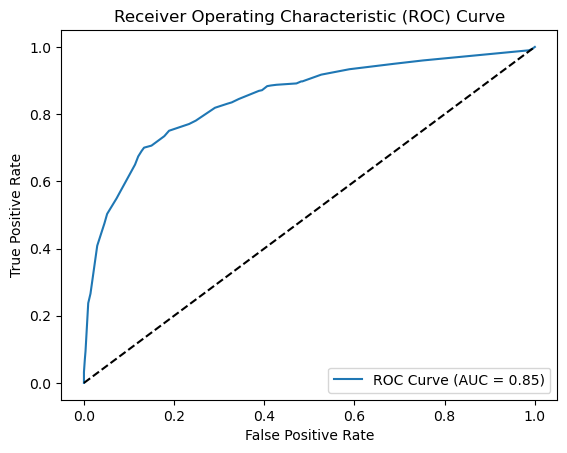

In [109]:
#roc curve- Trade off between false positives and true positives
def plot_roc_curve(y_true=y_test, y_pred_prob=y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve()